# Radar plots that resemble RadarScope
### This version of the code creates images and animations for NEXRAD level 2 data

In [1]:
'''
Import the nessesary Packages/ Libraries
'''
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta # read/ display the time
import cartopy.crs as ccrs # Map projections
import cartopy.feature as cfeature # Map features
import cartopy.io.shapereader as shpreader # Helps read shapefiles; can be used to add additional features to the map
from metpy.plots import ctables, USCOUNTIES, add_timestamp # Color tables, US County lines, and function to add time to plots
from metpy.io import Level2File # Function that reads level 2 NEXRAD Data
from pyproj import Geod # Used to change cartesian/ polar coordinates to latitude and longitude
import boto3 # Accessing radar data
import botocore
from botocore.client import Config

In [2]:
'''
The following function accesses level 2 nexrad data files. For more information
search docs.opendata.aws/noaa-nexrad/readme.html

The function takes two arguments, the date and the station. The date MUST
be a datetime object. The station must be a four character string, 
the station ID.
'''

def access_datafiles(d, station):
    s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED, 
                                            user_agent_extra='Resource'))
    bucket = s3.Bucket('noaa-nexrad-level2')
    prefix = f'{d:%Y}/{d:%m}/{d:%d}/{station}/{station}{d:%Y%m%d_%H}'
    objects = []
    for obj in bucket.objects.filter(Prefix = prefix):
        print(obj.key)
        objects.append(obj)
    return objects

In [3]:
'''
Function that will be called to plot the radar data. Accepts the output of Level2File() 
and a matplotlib.axes.Axes object as arguements.
'''

def plot_radar(f, ax):
    sweep = 0

    az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

    ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
    ref_range = np.arange(ref_hdr.num_gates) * ref_hdr.gate_width + ref_hdr.first_gate

    ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])
    radarfilter = f.clutter_filter_bypass_map['data'][0]

    truedata = []
    for data_ray in ref:
        rows = []
        for data_point in data_ray:
            if data_point < 10:
                data_point = np.nan
                rows.append(data_point)
            else:
                rows.append(data_point)
        truedata.append(rows)

    truedata = np.array(truedata)
    data = np.ma.array(truedata)
    data[np.isnan(data)] = np.ma.masked
    
    lat = f.sweeps[sweep][0][1].lat
    lon = f.sweeps[sweep][0][1].lon
    
    g = Geod(ellps='clrk66')
    
    center_lat = np.ones([len(az),len(ref_range)])*lat    
    center_lon = np.ones([len(az),len(ref_range)])*lon
    az2D = np.ones_like(center_lat)*az[:,None]
    rng2D = np.ones_like(center_lat)*np.transpose(ref_range[:,None])*1000
    lon,lat,back=g.fwd(center_lon,center_lat,az2D,rng2D)

    norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity',-20,0.5)
    mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, shading = 'auto')
    
    data_time = f.dt
    time_stamp = add_timestamp(ax, time=data_time)
    time_stamp.set_font('Times New Roman')
    time_stamp.set_fontsize(36)
    
    return mesh, time_stamp

In [4]:
'''
Function that plots city names. Accepts an extent (a list of latitudes and longitudes
that define the edges of the plot) and a matplotlib.axes.Axes object as arguments.
'''

def plot_cities(extent, ax):
    pop = cfeature.NaturalEarthFeature(
            category = 'cultural',
            name = 'populated_places',
            scale = '10m',
            facecolor = 'none')
    pop = shpreader.natural_earth(resolution='10m', category='cultural', name='populated_places')
    shp = shpreader.Reader(pop)

    lats = []
    lons = []
    USCities = []
    populations = []
    for record in shp.records():
        country = record.attributes['SOV0NAME']
        lat = record.attributes['LATITUDE']
        lon = record.attributes['LONGITUDE']
        population = record.attributes['POP_MAX']
        if extent[0]<lon<extent[1] and extent[2]<lat<extent[3]:
            USCities.append(record.attributes['NAME'])
            lats.append(lat)
            lons.append(lon)
            populations.append(population)
    if len(populations) > 30:
        Sorted = sorted(populations, reverse = True)[0:29]
        maximum = max(Sorted)
        minimum = min(Sorted)
    else:
        maximum = max(populations)
        minimum = min(populations)

    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    for i in range(len(USCities)):
        if minimum <= populations[i] <= maximum:
            ax.annotate(USCities[i], (lons[i],lats[i]), 
                        c = 'lightyellow', xycoords = transform, size = 24, 
                        fontfamily = 'Times New Roman')

In [5]:
'''
Choose a the day, hour, and station for the plots. Then call the access_files()
funciton.
'''
d = datetime(2020, 3, 28, 23)
station = 'KDVN'
bucketlist = access_datafiles(d, station)

2020/03/28/KDVN/KDVN20200328_230125_V06
2020/03/28/KDVN/KDVN20200328_230633_V06
2020/03/28/KDVN/KDVN20200328_231224_V06
2020/03/28/KDVN/KDVN20200328_232025_V06
2020/03/28/KDVN/KDVN20200328_232617_V06
2020/03/28/KDVN/KDVN20200328_233208_V06
2020/03/28/KDVN/KDVN20200328_233801_V06
2020/03/28/KDVN/KDVN20200328_234405_V06
2020/03/28/KDVN/KDVN20200328_235010_V06
2020/03/28/KDVN/KDVN20200328_235629_V06
2020/03/28/KDVN/KDVN20200328_235629_V06_MDM


In [6]:
'''
Function that creates a Single Image. Accepts two arguments, the list of buckets 
created by access_files() and the index of the file said list to be plotted.
'''
def single_image(bucketlist, number): 
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize = (20,20))
    ax = plt.subplot(projection = proj)
    ax.set_facecolor('black')

    extent = [-91,-90,40.5,41.5]
    ax.set_extent(extent)

    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor = 'white',
                   linewidth = 0.5, zorder = 0)
    roads = cfeature.NaturalEarthFeature(
            category = 'cultural',
            name = 'roads',
            scale = '10m',
            facecolor = 'none'
            )
    ax.add_feature(roads, edgecolor = 'lightblue', linewidth = 0.5)
    plot_cities(extent,ax)

    f = Level2File(bucketlist[number].get()['Body'])
    plot_radar(f, ax)
    
    return fig


In [7]:
'''
Creating Animation
'''
def create_animation(bucketlist):
    
    from matplotlib.animation import ArtistAnimation #import function to do the animation
    
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(30,20))
    ax = plt.subplot(projection = proj)
    ax.set_facecolor('black')


    artists = []

    '''
    User may change extent depending on the location of the plot. Setting the extent
    is not necessary, but if it is not set the plot will be fairly zoomed out.
    '''
    extent = [-91.5,-89.5,40.5,41.5]
    ax.set_extent(extent)

    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor = 'white', linewidth = 1)
    roads = cfeature.NaturalEarthFeature(
            category='cultural',
            name='roads',
            scale='10m',
            facecolor='none')
    ax.add_feature(roads, edgecolor='lightblue', linewidth = 1)
    plot_cities(extent, ax)

    artists = []
    for file in bucketlist[0:len(bucketlist)-1]:
        f = Level2File(file.get()['Body'])
        mesh, time_stamp = plot_radar(f, ax)
        artists.append([mesh,time_stamp])
    plt.rcParams['animation.html'] = 'jshtml'
    anim = ArtistAnimation(fig,artists, interval = 400)
    return anim
    

Message 13 segments out of sync -- read -1 but on 2
Message 13 segments out of sync -- read -1 but on 3
Message 13 segments out of sync -- read -1 but on 4
Message 13 segments out of sync -- read -1 but on 5
Message 13 left data -- Used: 46080 Avail: 57605
C:\Users\Jonathan DeGraw\.conda\envs\MetPy\lib\site-packages\cartopy\mpl\geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


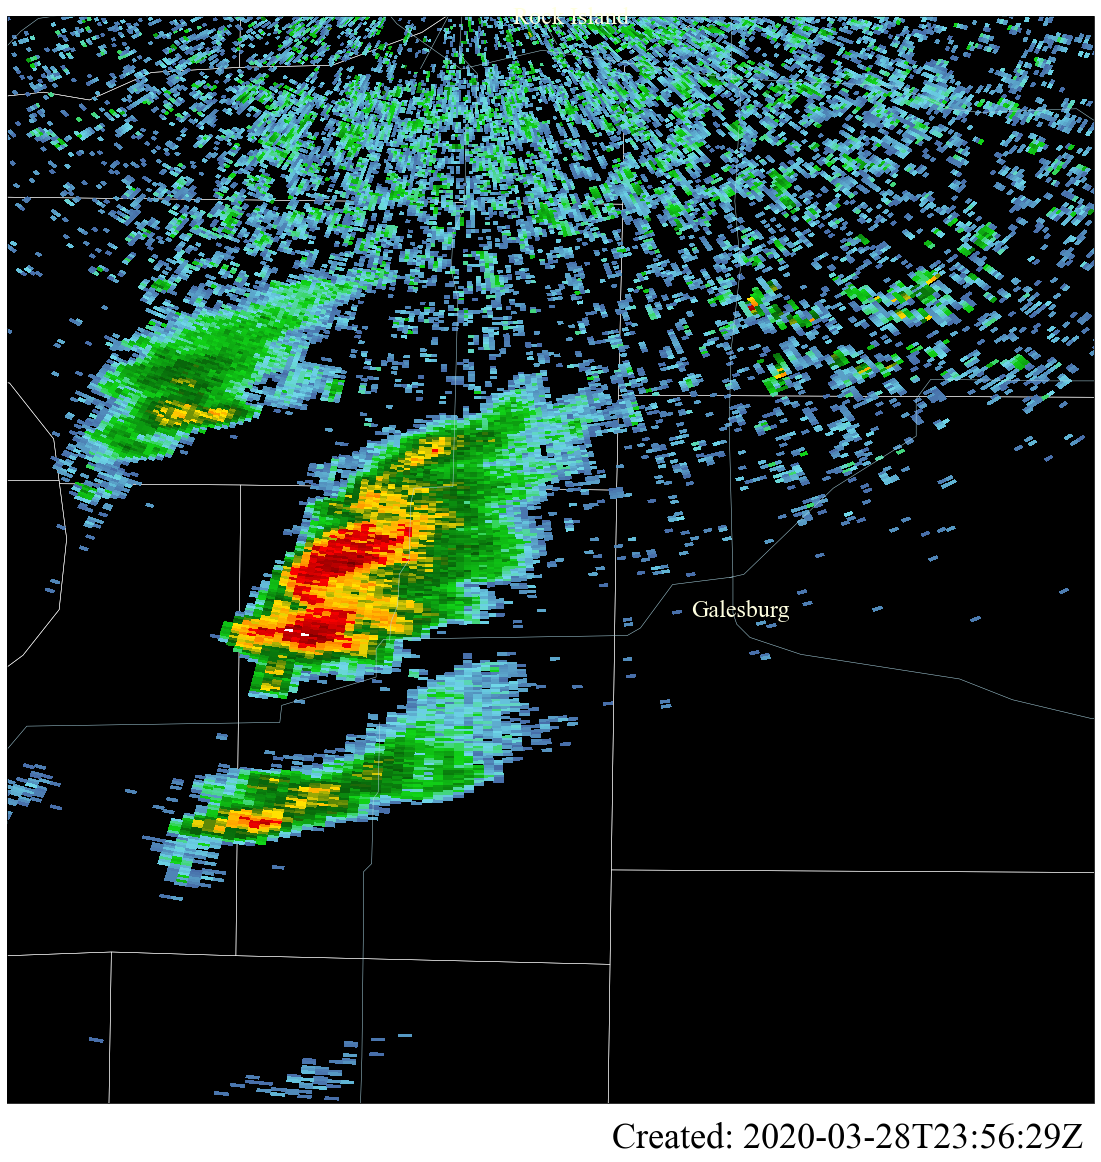

In [8]:
fig = single_image(bucketlist, 9)

Message 13 segments out of sync -- read -1 but on 2
Message 13 segments out of sync -- read -1 but on 3
Message 13 segments out of sync -- read -1 but on 4
Message 13 segments out of sync -- read -1 but on 5
Message 13 left data -- Used: 46080 Avail: 57605
Message 13 segments out of sync -- read -1 but on 2
Message 13 segments out of sync -- read -1 but on 3
Message 13 segments out of sync -- read -1 but on 4
Message 13 segments out of sync -- read -1 but on 5
Message 13 left data -- Used: 46080 Avail: 57605
Message 13 segments out of sync -- read -1 but on 2
Message 13 segments out of sync -- read -1 but on 3
Message 13 segments out of sync -- read -1 but on 4
Message 13 segments out of sync -- read -1 but on 5
Message 13 left data -- Used: 46080 Avail: 57605
Message 13 segments out of sync -- read -1 but on 2
Message 13 segments out of sync -- read -1 but on 3
Message 13 segments out of sync -- read -1 but on 4
Message 13 segments out of sync -- read -1 but on 5
Message 13 left data 

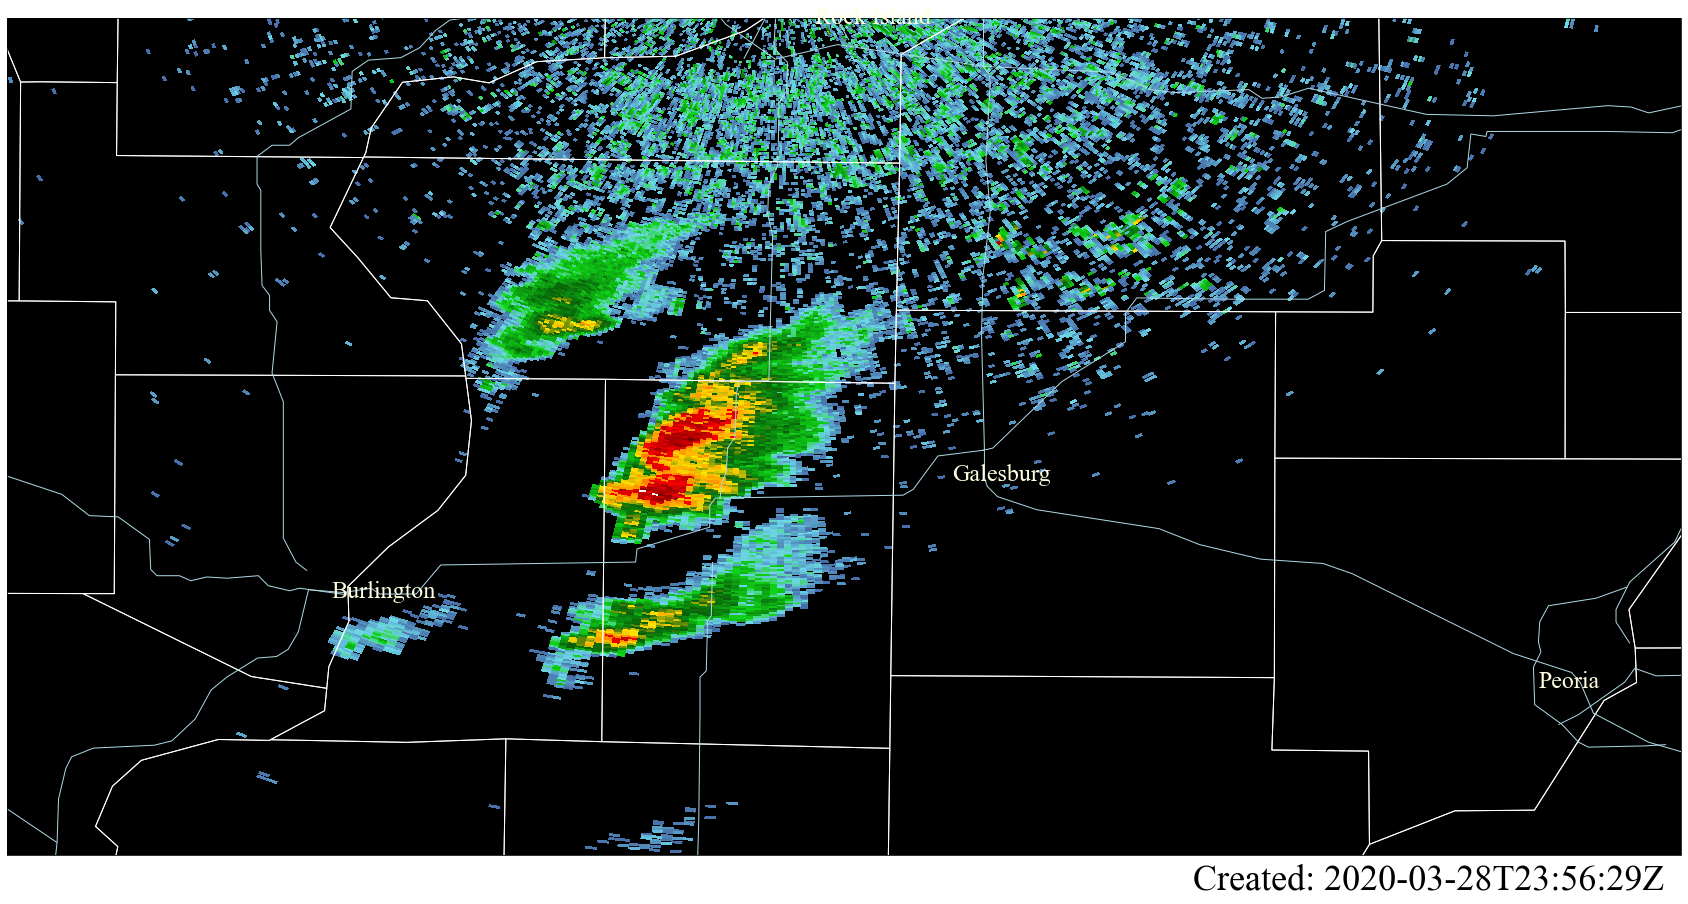

In [9]:
anim = create_animation(bucketlist)
anim

In [10]:
'''
Save image/animation to computer
'''
plt.savefig('Insert-imagename-here.png')
anim.save('Radar2020-03-28_T2356_Level2_Small.gif', writer = 'imagemagick')

'\nSave image/animation to computer\n'